In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

train_df = trainid_df.join(properties_df)

In [4]:
# Try diffusing when propertylandusetypeid is 261.0 and when it is not.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()

vals_df['abslogerror'] = np.abs(vals_df.logerror.values)

In [5]:
# Define simple gradient descent for linear fit.

def l1linearfit(X, y, niterations, rate):
    npoints, nvars = X.shape
    coefficients = np.zeros(nvars)
    errors = []
    for i in range(niterations):
        grad = np.zeros(X.shape)
        ypredict = np.dot(X, coefficients.T)
        error = ypredict - y
        
        # Get grad update matrix
        # First the positive ones
        grad[error >= 0] = X[error >= 0]
        grad[error < 0] = -1 * X[error < 0]
        
        grad = np.sum(grad, axis = 0)
        coefficients -= grad * rate
        
        error = np.abs(error)
        error = np.mean(error)
        errors.append(error)
        
    return coefficients, errors

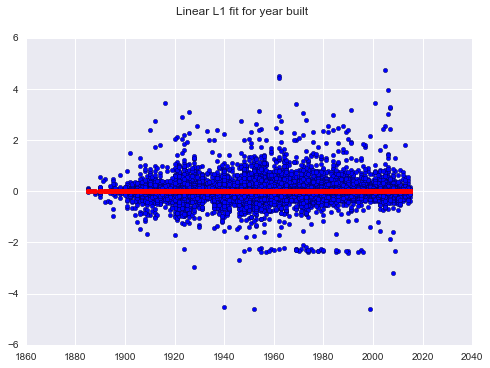

0.067578007794066863

In [6]:
# Let's get a benchmark of using just yearbuilt by looking at linear fit minimizing the L1 norm.

X = vals_df.yearbuilt.values.reshape(-1,1)
npoints, nvars = X.shape
X = np.hstack((X, np.full((npoints, 1), 1.0)))

y = vals_df.logerror.values

coeffs, errors = l1linearfit(X, y, 50, 10**-13)
ypredict = np.dot(X, coeffs.T)

plt.scatter(vals_df.yearbuilt, y)
plt.scatter(vals_df.yearbuilt, ypredict, color = 'red')
plt.suptitle('Linear L1 fit for year built')
plt.show()

abserror = np.abs(ypredict - y)
abserror = np.mean(abserror)
abserror

In [7]:
# Let's benchmark the percentage change in original error. That is, assuming the Zillow model is correct.

origerror = np.abs(vals_df.logerror)
origerror = np.mean(origerror)

(abserror - origerror) / origerror

-0.0047201299480441796

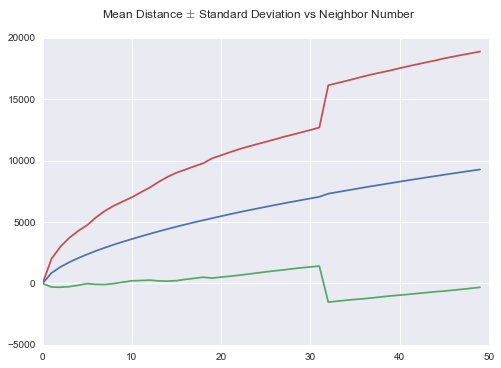

In [8]:
# Get an idea of how large the distances are for up to 20 neighbors
nbrs = NearestNeighbors(50)
nbrs.fit(vals_df[['latitude', 'longitude']])
points = vals_df[['latitude', 'longitude']]
distances, indices = nbrs.kneighbors(points)
meandist = np.mean(distances, axis = 0)
stddist = np.std(distances, axis = 0)

plt.plot(meandist)
plt.plot(meandist - stddist)
plt.plot(meandist + stddist)
plt.suptitle('Mean Distance $\pm$ Standard Deviation vs Neighbor Number')
plt.show()

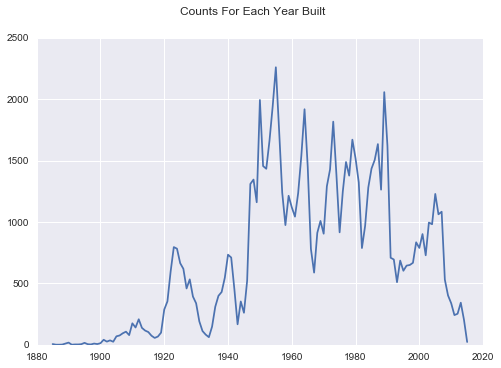

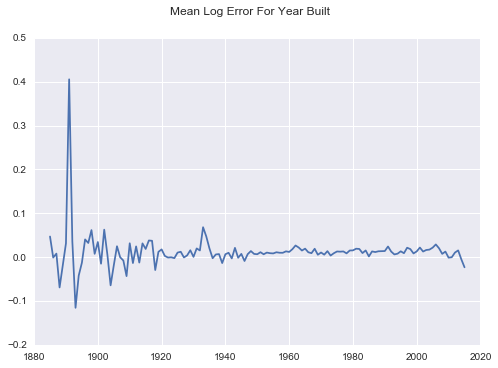

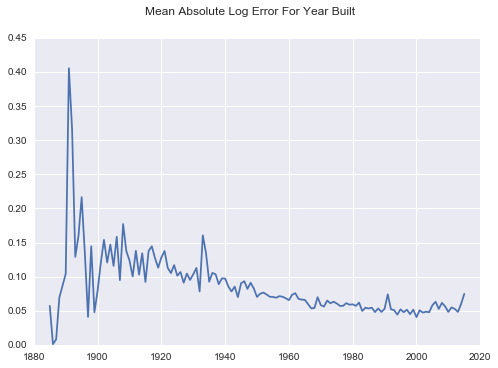

In [9]:
# Let's investigate diffusing the year built.

grouped_df = vals_df.groupby('yearbuilt').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.suptitle('Counts For Each Year Built')
plt.show()

grouped_df = vals_df.groupby('yearbuilt').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.suptitle('Mean Log Error For Year Built')
plt.show()

plt.plot(grouped_df.index, grouped_df.abslogerror)
plt.suptitle('Mean Absolute Log Error For Year Built')
plt.show()

In [25]:
# Get a graph of smallest L1 norm for L1 linear fit of diffusion as func of num neighbors to use in diffusion.

niterations = 80     # Number of iterations to do gradient descent on L1 norm.
learningrate = 10**-14     # Scaling factor for gradient descent.

diffinit = vals_df.yearbuilt.values.T     # Initial values of diffusions
coords = vals_df[['latitude', 'longitude']].values    # Coords for diffusions
diffusions = np.zeros(diffinit.shape)     # Will hold the actual value of the diffusions.

ks = range(1, 19, 2)     # Different possibilities of numbers of neighbors.
epsilons = np.arange(4, 6, 0.5)
epsilons = 10**epsilons # Possible epsilons to use in average weighting.
nbrs = NearestNeighbors()
nbrs.fit(coords)

errors = np.zeros((len(ks), len(epsilons)))

for i in range(len(ks)):
    k = ks[i]
    
    nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
    nbrdiffusions = diffinit[nbrindex]
    
    for j in range(len(epsilons)):
        epsilon = epsilons[j]
        
        weights = nbrdistance + epsilon
        weights = 1.0 / weights
        meandiffusions = weights * nbrdiffusions
        meandiffusions = np.sum(meandiffusions, axis = 1)
        meandiffusions /= np.sum(weights, axis = 1)
        newdiffusions = np.stack((meandiffusions, diffinit))
        diffusions = np.amax(newdiffusions, axis = 0)
        #diffusions = meandiffusions
        
        X = diffusions.reshape(-1,1)
        npoints, nvars = X.shape
        X = np.hstack((X, np.full((npoints, 1), 1.0)))
        y = vals_df.logerror.values.T
        coeffs, unusederrors = l1linearfit(X, y, niterations, learningrate)
        ypredict = np.dot(X, coeffs.T)
        
        abserror = np.abs(ypredict - y)
        abserror = np.mean(abserror)
        errors[i, j] = abserror
    
errors = errors.T    # Each row is for a specific epsilon.

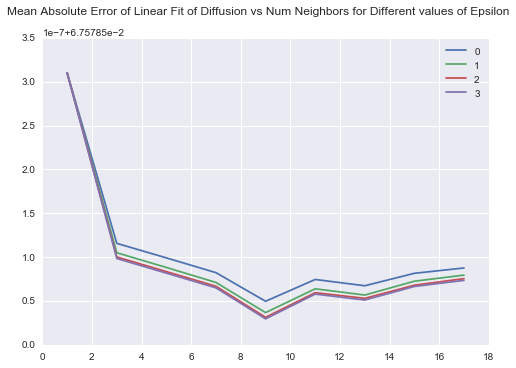

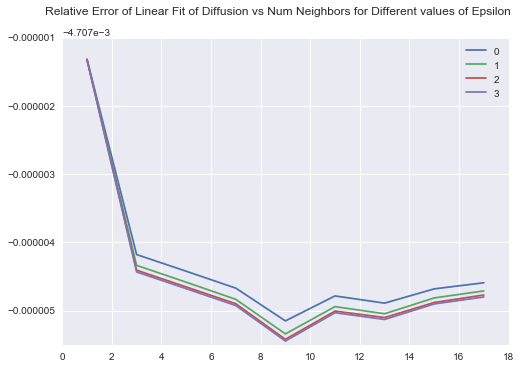

In [26]:
# Look at graphs of errors

nepsilon, nks = errors.shape

curves = []
names = [str(i) for i in range(nepsilon)]

for i in range(nepsilon):
    curve, = plt.plot(ks, errors[i])
    curves.append(curve)
plt.legend(curves, names)
plt.suptitle('Mean Absolute Error of Linear Fit of Diffusion vs Num Neighbors for Different values of Epsilon')
plt.show()

relerror = (errors - origerror) / origerror
for i in range(nepsilon):
    curve, = plt.plot(ks, relerror[i])
    curves.append(curve)
plt.legend(curves, names)
plt.suptitle('Relative Error of Linear Fit of Diffusion vs Num Neighbors for Different values of Epsilon')
plt.show()

In [27]:
# Now set up diffusion variables to use in the rest of analysis.

k = 9
epsilon = 10**5

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
nbrdiffusions = diffinit[nbrindex]

weights = nbrdistance + epsilon
weights = 1.0 / weights
meandiffusions = weights * nbrdiffusions
meandiffusions = np.sum(meandiffusions, axis = 1)
meandiffusions /= np.sum(weights, axis = 1)
newdiffusions = np.stack((meandiffusions, diffinit))
diffusions = np.amax(newdiffusions, axis = 0)
#diffusions = meandiffusions
        
vals_df['diffusions'] = diffusions

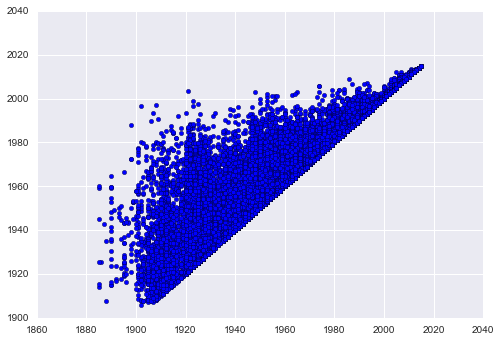

In [28]:
# Plot diffusions vs year built.

plt.scatter(vals_df.yearbuilt, vals_df.diffusions)
plt.show()

In [29]:
# Let's try linear fit of year built and diffusion.

X = vals_df[['yearbuilt', 'diffusions']].values
npoints, nvars = X.shape
X = np.hstack((X, np.full((npoints, 1), 1.0)))
y = vals_df.logerror

coeffs, errors = l1linearfit(X, y, 400, 10**-12)
ypredict = np.dot(X, coeffs.T)
abserror = np.abs(ypredict - y)
abserror = np.mean(abserror)
abserror

relerror = (abserror - origerror) / origerror
relerror

C:\Users\Matthew\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  
C:\Users\Matthew\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  from ipykernel import kernelapp as app


-0.004674528182440311

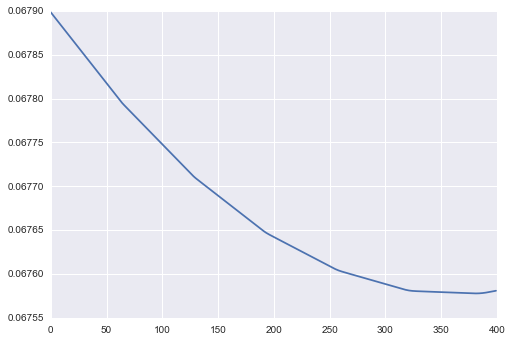

In [30]:
plt.plot(errors)
plt.show()

In [31]:
# Function for binning

def makebins(vals, nbins = 20):
    maxval = np.amax(vals)
    minval = np.amin(vals)
    newvals = (vals - minval) / (maxval - minval) * nbins
    newvals = newvals.astype(int)
    newvals = newvals * (maxval - minval) / nbins + minval
    return newvals

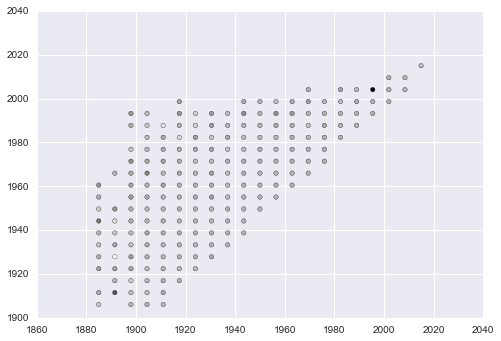

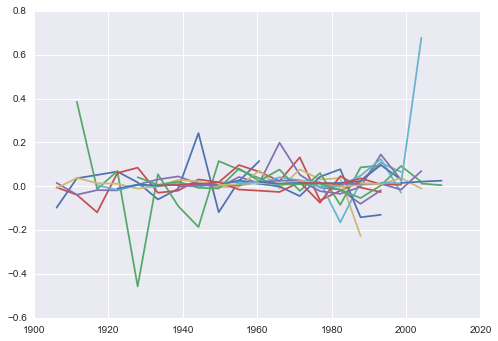

In [32]:
# Try binning the values

bin1 = makebins(vals_df.yearbuilt)
bin2 = makebins(vals_df.diffusions)

vals_df['bins1'] = bin1
vals_df['bins2'] = bin2
grouped_df = vals_df.groupby(['bins1', 'bins2']).mean()
colors = grouped_df.logerror
bincoords = grouped_df.index.values

bincoords = np.array([list(t) for t in bincoords]).T

plt.scatter(bincoords[0], bincoords[1], c = colors)
plt.show()

bin1vals = np.unique(bincoords[0])
for bin1val in bin1vals:
    indices = bincoords[0] == bin1val
    x = bincoords[1][indices]
    y = colors[indices]
    plt.plot(x,y)
plt.show()